## Implement the LSTM($\lambda$) off-line formulation and recursive formulation
First define the FiveStates and MarkovChain Environment using gym interface

In [1]:
!pip install gym
!pip install matlibplot

    100% |████████████████████████████████| 1.5MB 821kB/s 
    100% |████████████████████████████████| 1.0MB 1.2MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /content/.cache/pip/wheels/55/10/54/738634b5a554fc825283685db35371481d66137018ad2c9365
Successfully built gym
  Could not find a version that satisfies the requirement matlibplot (from versions: )
No matching distribution found for matlibplot


In [0]:
import gym
import numpy as np

class FiveStates(gym.Env):
    # doesn't support rendering
    metadata = {'render.modes': []}
    action_space = None

    def __init__(self):
        self.nb_states = 5
        self.state = None
        self.feature_dim = 5
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.feature_dim,), dtype=np.float)
        self.state_transit_prob = [
            [0.42, 0.13, 0.14, 0.03, 0.28],
            [0.25, 0.08, 0.16, 0.35, 0.15],
            [0.08, 0.20, 0.33, 0.17, 0.22],
            [0.36, 0.05, 0.00, 0.51, 0.07],
            [0.17, 0.24, 0.19, 0.18, 0.22]
        ]
        self.feature_vec = [
            [74.29, 34.61, 73.48, 53.29, 7.79],
            [61.60, 48.07, 34.68, 36.19, 82.02],
            [97.00, 4.88, 8.51, 87.89, 5.17],
            [41.10, 40.13, 64.63, 92.67, 31.09],
            [7.76, 79.82, 43.78, 8.56, 61.11]
        ]

        self.reward = [
            [104.66, 29.69, 82.36, 37.49, 68.82],
            [75.86, 29.24, 100.37, 0.31, 35.99],
            [57.68, 65.66, 56.95, 100.44, 47.63],
            [96.23, 14.01, 0.88, 89.77, 66.77],
            [70.35, 23.69, 73.41, 70.70, 85.41]
        ]

        # re-normalize transit_prob
        self.state_transit_prob = [list(np.array(prob) / np.sum(prob)) for prob in self.state_transit_prob]

    def step(self, action=None):
        # next state
        state_new = np.random.choice(np.arange(self.nb_states), 1, p=self.state_transit_prob[self.state])[0]
        reward = self.reward[self.state][state_new]
        self.state = state_new
        return np.array(self.feature_vec[self.state]).reshape(-1, 1), reward, False, {}

    def reset(self):
        # random initial state
        self.state = np.random.randint(self.nb_states)
        return np.array(self.feature_vec[self.state]).reshape(-1, 1)

    def render(self, mode=None):
        pass


class MarkovChain(gym.Env):

    metadata = {'render.modes': []}
    action_space = None

    def __init__(self):
        self.nb_states = 13
        self.feature_dim = 4
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.feature_dim,), dtype=np.float)
        self.feature_vec = [
            [0, 0, 0, 0],
            [0, 0, 1/4, 3/4],
            [0, 0, 1/2, 1/2],
            [0, 0, 3/4, 1/4],
            [0, 0, 1, 0],
            [0, 1/4, 3/4, 0],
            [0, 1/2, 1/2, 0],
            [0, 3/4, 1/4, 0],
            [0, 1, 0, 0],
            [1/4, 3/4, 0, 0],
            [1/2, 1/2, 0, 0],
            [3/4, 1/4, 0, 0],
            [1, 0, 0, 0]
        ]
        self.state_transit_prob = None
        self.reward = None
        self.state = None
        self._init_trans_prob_and_reward()

    def _init_trans_prob_and_reward(self):
        self.state_transit_prob = np.zeros((self.nb_states, self.nb_states))
        self.reward = np.zeros((self.nb_states, self.nb_states))
        for i in range(self.nb_states-1, 1, -1):
            self.state_transit_prob[i][i-1] = 0.5
            self.reward[i][i-1] = -3
            self.state_transit_prob[i][i-2] = 0.5
            self.reward[i][i-2] = -3
        self.state_transit_prob[1][0] = 1
        self.reward[1][0] = -2

    def step(self, action=None):
        state_new = np.random.choice(np.arange(self.nb_states), 1, p=self.state_transit_prob[self.state])[0]
        reward = self.reward[self.state][state_new]
        self.state = state_new
        isstop = False
        if self.state == 0:
            isstop = True
        return np.array(self.feature_vec[self.state]).reshape(-1, 1), reward, isstop, {}

    def reset(self):
        # the starting state
        self.state = 12
        return np.array(self.feature_vec[self.state]).reshape(-1,1)

    def render(self, mode=None):
        pass

## offline LSTD(lambda) and online LSTD(lambda)

In [0]:
def LSTD_lambda_offline(env, lambd=0.4, discount = 0.9, iterations=10000, timesteps=1000):
    '''
    Do not use discount for episodic task in the offline formula.
    :param env: FiveStates or Markov Chain
    :param lambd: TD(lambda) hyperparameter, paper reported that 0.4 is optimal
    :param discount: only useful for ergodic task, aka the FiveStates problem
    :param iterations: number of trajectories to experiment
    :param timesteps: maximum time steps for each trajectory
    :return: learned parameters
    '''
    if isinstance(env, MarkovChain):
        discount = 1
    feature_dim = env.feature_dim
    A = np.zeros((feature_dim, feature_dim))
    b = np.zeros((feature_dim, 1))
    for run in range(iterations):
        # independent trajectory
        obs = env.reset() # trace vector
        z = obs
        for t in range(timesteps):
            new_obs, reward, done, info = env.step()
            A += np.dot(z,np.transpose((obs - discount*new_obs)))
            b += z*reward
            z = discount*lambd*z + new_obs
            obs = new_obs
            if done is True:
                break
    theta = np.dot(np.linalg.inv(A),b)
    return theta


def LSTD_lambda_online(env, lambd=0.4, epsilon=0.1, discount = 0.9, iterations=10000, timesteps=1000):
    '''
    incremental version using the Sherman-Morrison rule
    :param env: FiveStates or Markov Chain
    :param lambd: TD(lambda) hyperparameter, paper reported that 0.4 is optimal
    :param discount: only useful for ergodic task, aka the FiveStates problem
    :param iterations: number of trajectories to experiment
    :param timesteps: maximum time steps for each trajectory
    :return: learned parameters
    '''
    if isinstance(env, MarkovChain):
        discount = 1
    thetas = []
    feature_dim = env.feature_dim
    optimal_theta = np.array([-24, -16, -8, 0]).reshape(-1, 1)
    A = epsilon*np.eye(feature_dim)
    b = np.zeros((feature_dim, 1))
    for run in range(iterations):
        # independent trajectory
        obs = env.reset()  # trace vector
        z = obs
        for t in range(timesteps):
            new_obs, reward, done, info = env.step()
            v = np.dot(A.T, (obs-discount*new_obs))
            A -= np.dot(np.dot(A, z), v.T)/(1+np.dot(v.T, z))
            b += z * reward
            theta = np.dot(A, b)
            thetas.append(theta)
            z = discount*lambd * z + new_obs
            obs = new_obs
            if done is True:
                break
    return thetas

Prelinminary experiments on MarkovChain example

*   lambda is set to 0.4 for both case
*   not discounted; for five states (which is an ergodic task) discounting would be necessary



offline LSTD(lambda) over 1000 trajectories
learned theta:
[-24.0897531848506, -15.998537642753215, -8.035053456017526, -0.010762438525590667]
RMSE 0.048482851456295904
online LSTD(lambda)


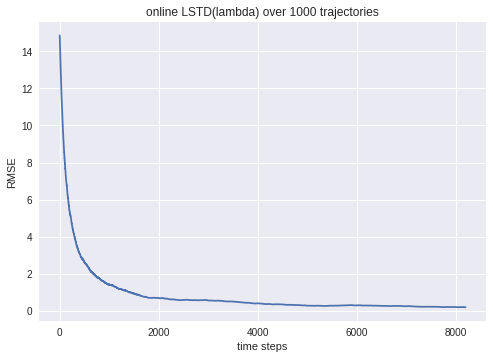

final learned theta
[-23.616321745968804, -15.89774737669852, -7.898758087919651, -0.04655699741193331]
final rmse 0.20620504380237709


In [13]:
import matplotlib.pyplot as plt
feature_dim = 4
optimal_theta = np.array([-24, -16, -8, 0]).reshape(-1, 1)
print('offline LSTD(lambda) over 1000 trajectories')
theta = LSTD_lambda_offline(MarkovChain(), iterations=1000)
print('learned theta:')
print(list(theta.reshape(-1)))
# calculate RMS error
rmse = np.sqrt(np.sum(np.square(theta - optimal_theta)) / feature_dim)
print('RMSE',rmse)

print('online LSTD(lambda)')
thetas = LSTD_lambda_online(MarkovChain(), iterations=1000)
rmses = [np.sqrt(np.sum(np.square(theta - optimal_theta)) / feature_dim) for theta in thetas]
plt.figure()
plt.title('online LSTD(lambda) over 1000 trajectories')
plt.ylabel('RMSE')
plt.xlabel('time steps')
plt.plot(rmses)
plt.show()
print('final learned theta')
print(list(thetas[-1].reshape(-1)))
print('final rmse', rmses[-1])

On FiveStates example

In [15]:
feature_dim = 5
# we don't know the optimal theta for FiveStates example
print('offline LSTD(lambda) over 100 trajectories')
theta = LSTD_lambda_offline(FiveStates(), iterations=100)
print('learned theta:')
print(list(theta.reshape(-1)))

print('online LSTD(lambda) over 100 tracjectories')
thetas = LSTD_lambda_online(FiveStates(), iterations=100)
print('final learned theta')
print(list(thetas[-1].reshape(-1)))

offline LSTD(lambda) over 100 trajectories
learned theta:
[3.9923729702586725, 9.357850905734562, -0.9251141331281509, 3.140499497397901, -1.1296970944329203]
online LSTD(lambda) over 100 tracjectories
final learned theta
[3.9920780505291242, 9.377646076509503, -0.927521384103855, 3.142860529674409, -1.1423204842899803]


## Reproduce Experiments